# Neural Networks in PyTorch - Handwritten Digits

**Objective:** Build a Feed Forward Neural Network in order to classify an input image of handwritten digits from 0-9.

## MNIST Dataset

MNIST is a dataset of handwritten digits, containing 60,000 training images and 10,000 testing images. All images are in grayscale, each with a size of 28x28. 

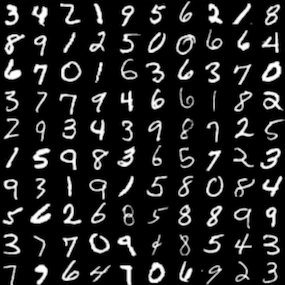

## Neural Network architecture

The network will have:
- 784 input neurons, since each image is of size 28x28, hence one has 784 pixels per image/instance. 
- 2 hidden layers, each with 400 hidden layer neurons 
- 10 output neurons, since the model needs to classify 10 different digits, 0 till 9. 

![nn mnist](https://user-images.githubusercontent.com/30661597/61593615-5eb8bf00-ac14-11e9-8087-f880971b3543.png)

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

Defining the hyperparameters:

In [3]:
input_size = 784       #Number of input neurons (image pixels)
hidden_size = 400      #Number of hidden neurons
out_size = 10          #Number of classes (0-9)
epochs = 10            #How many times we pass the entire dataset into the network
batch_size = 100       #Input size of the data during one iteration
learning_rate = 0.001  #Implies how fast the learning occurs

Train and test dataset:

In [4]:
train_dataset = datasets.MNIST(root='./data',
                               train = True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                               train = False,
                               transform=transforms.ToTensor())
                               

In [5]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#Make Data iterable by loading it to a loader. The dataset is divided into n batchs of data.
#Shuffle the training data to make it independant of the order
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
#Visualize the train loader
for i, (images, labels) in enumerate(train_loader):
    print('Images size: ', images.size())
    #Reshape the image tensor
    images = images.view(-1,input_size)
    print('Reshaped Images size: ', images.size())
    
    print('Labels size: ', labels.size())
    #Reshape the labels tensor
    labels = labels.view(-1,1)
    print('Reshaped labels size: ', labels.size())
    if i == 3:
        break

Images size:  torch.Size([100, 1, 28, 28])
Reshaped Images size:  torch.Size([100, 784])
Labels size:  torch.Size([100])
Reshaped labels size:  torch.Size([100, 1])
Images size:  torch.Size([100, 1, 28, 28])
Reshaped Images size:  torch.Size([100, 784])
Labels size:  torch.Size([100])
Reshaped labels size:  torch.Size([100, 1])
Images size:  torch.Size([100, 1, 28, 28])
Reshaped Images size:  torch.Size([100, 784])
Labels size:  torch.Size([100])
Reshaped labels size:  torch.Size([100, 1])
Images size:  torch.Size([100, 1, 28, 28])
Reshaped Images size:  torch.Size([100, 784])
Labels size:  torch.Size([100])
Reshaped labels size:  torch.Size([100, 1])


Each batch has 100 images/instances, each of them with 784 features and 1 true label.

## Definition of the Network Class

In [9]:
class Net(nn.Module):  #Net class inherits from nn.Module
    def __init__(self, input_size, hidden_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) #First linear layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) #Second linear Layer
        self.fc3 = nn.Linear(hidden_size, out_size)  #Third linear layer
        self.relu = nn.ReLU()  #ReLU activation function
        self.init_weights()  #Initialize the weights when instantiating
    
    def init_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    #Forward Propagation    
    def forward(self, x):
        #Calculate the inputs of the first hidden layer
        out = self.fc1(x) 
        #Activate the inputs of the first hidden layer
        out = self.relu(out)
        #Calculate the inputs of the second hidden layer
        out = self.fc2(out)
        #Activate the inpits of the second hidden layer
        out = self.relu(out)
        #Calculate the outputs of the network
        out = self.fc3(out)
        
        return out
        

## Instantiation of the network class and definition of the network functions

In [10]:
#Create an object of the Net class, which represents the network
net = Net(input_size, hidden_size, out_size)
#Check for GPU
CUDA = torch.cuda.is_available()
#Move the network to the GPU if available
if CUDA:
    net = net.cuda()

#Loss function. The Cross Entropy Loss comes along with Softmax. 
#Therefore, there is no need to specify Softmax as well
criterion = nn.CrossEntropyLoss()

#Adam Gradient Descent
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [11]:
len(list(net.parameters()))

6

We have 6 arrays of parameters, 3 weights matrices (W1, W2, W3) and 3 biases vectors (b1, b2, b3). 

In [12]:
for array in net.parameters():
    print(array.shape)

torch.Size([400, 784])
torch.Size([400])
torch.Size([400, 400])
torch.Size([400])
torch.Size([10, 400])
torch.Size([10])


## Train the network

In [13]:
###Train the Network###

#Initialize the list that contains the losses for every epoch
train_loss = []
train_accuracy = []
#Outter Loop: loops through the number of epochs
for epoch in range(epochs):
    #Number of intances classified correctly for each iteration
    correct_train = 0
    running_loss = 0
    #Inner Loop: iteration loop over the mini batchs of the Data Loader
    #Each batch has 100 images, each with 784 features/pixels
    for i, (images, labels) in enumerate(train_loader):
        
        #Flatten the image from size (batch,grey_scale,h_pixel,vertical_pixel) --->(100,1,28,28)
        #to size (100,784) 
        images = images.view(-1, 28*28)
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        
        #Forward Propagation being the input the minibatch of images
        outputs = net(images)
        #Calculate the predictions
        #Note: torch.max returns two arguments
        #1 - The Actual maximum value
        #2 - Index of the maximum value
        #As the prediction I actually want the index location of each maximum value
        _, predicted = torch.max(outputs.data, dim = 1)
        if CUDA:
            #There's no implementation of .sum() in the GPU
            correct_train += (predicted.cpu() == labels.cpu()).sum()
        else: 
            correct_train += (predicted == labels).sum()
            
        #Calculate the training loss 
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        #Reset the gradients
        optimizer.zero_grad()
        #Gradients calculation with Backpropagation
        loss.backward()
        #Update the weights using the Adam Optimizer
        optimizer.step()
        
    print('Epoch [{}/{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}'.format
         (epoch+1, epochs, running_loss/len(train_loader), (100*correct_train.double()/len(train_dataset))))
    
    train_loss.append(running_loss/len(train_loader))
    train_accuracy.append(100*correct_train.double()/len(train_dataset))
        
        
        

Epoch [1/10], Training Loss: 0.237, Training Accuracy: 93.057
Epoch [2/10], Training Loss: 0.085, Training Accuracy: 97.383
Epoch [3/10], Training Loss: 0.054, Training Accuracy: 98.273
Epoch [4/10], Training Loss: 0.037, Training Accuracy: 98.793
Epoch [5/10], Training Loss: 0.029, Training Accuracy: 99.075
Epoch [6/10], Training Loss: 0.024, Training Accuracy: 99.157
Epoch [7/10], Training Loss: 0.018, Training Accuracy: 99.435
Epoch [8/10], Training Loss: 0.015, Training Accuracy: 99.515
Epoch [9/10], Training Loss: 0.016, Training Accuracy: 99.443
Epoch [10/10], Training Loss: 0.014, Training Accuracy: 99.518


## Visualize Training

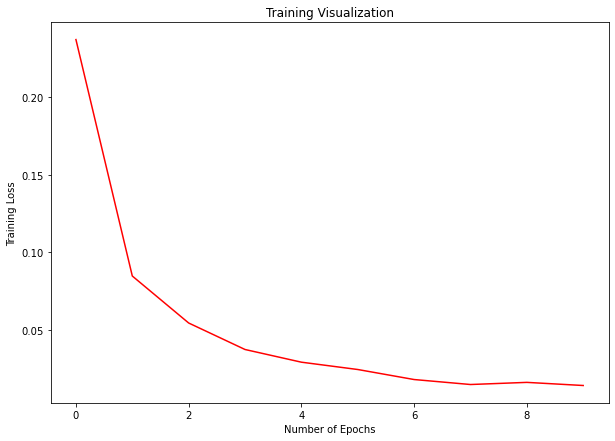

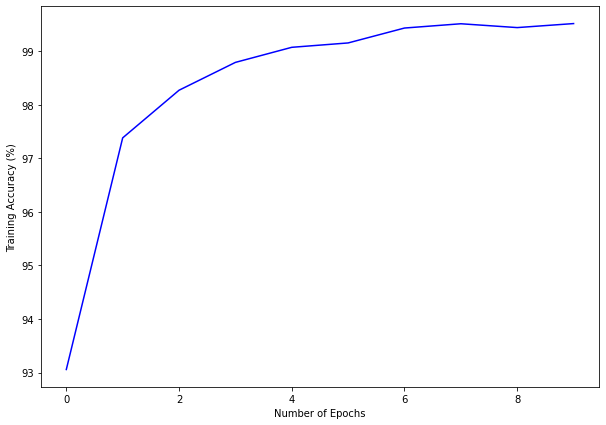

In [26]:
plt.figure(figsize = (10,7))

#Plot the training loss for each epoch
plt.plot(range(epochs), train_loss, 'r')
plt.title('Training Visualization')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.show()
#Plot the training accuracy for each epoch
plt.figure(figsize = (10,7))
plt.plot(range(epochs), train_accuracy, 'b')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy (%)')
plt.show()



The Training Loss is reducing very fast for the first epochs, which implies that the learning rate used is suitable. 

## Testing the Network

In [15]:
#Extract the test input data and the test labels
X_test = []
labels = []
i = 0
for (data, label) in test_dataset:
    i = i + 1
    if i == 1:
        X_test = data.view(-1,784)
        labels.append(label)
    else:
        #Reshape the instance/image
        labels.append(label)
        #Perform concatenation
        X_test = torch.cat((X_test, data.view(-1,784)), 0)
    

In [16]:
len(labels), type(labels)

(10000, list)

In [17]:
#Convert the test input data and the test labels to numpy arrays
X_test = X_test.numpy()

In [18]:
X_test.shape, type(X_test)

((10000, 784), numpy.ndarray)

In [19]:
y_test = np.array(labels, dtype='int64')
y_test, y_test.shape, type(y_test)

(array([7, 2, 1, ..., 4, 5, 6], dtype=int64), (10000,), numpy.ndarray)

In [20]:
predictions = net(torch.from_numpy(X_test))

In [21]:
_, y_pred = torch.max(predictions.data, 1)

In [22]:
y_pred, y_pred.shape

(tensor([7, 2, 1,  ..., 4, 5, 6]), torch.Size([10000]))

In [23]:
y_pred = y_pred.numpy()
y_pred, y_pred.shape

(array([7, 2, 1, ..., 4, 5, 6], dtype=int64), (10000,))

As a test score metric I decided to use the Accuracy Score, which is suitable since the dataset labels are pretty balanced. 

In [24]:
from sklearn.metrics import accuracy_score

Test accuracy score:

In [25]:
accuracy_score(y_test, y_pred)

0.9807

clearly the model is generalizing pretty well to the test data, since the predictions are correct 98 percent of the time.

## Extension of the training 

Here I'm going to calculate the test accuracy score for each epoch of the training, in order to check if early stopping can be advantageous. 

In [37]:
#Create an object of the Net class, which represents the network
net = Net(input_size, hidden_size, out_size)
#Check for GPU
CUDA = torch.cuda.is_available()
#Move the network to the GPU if available
if CUDA:
    net = net.cuda()

#Loss function. The Cross Entropy Loss comes along with Softmax. 
#Therefore, there is no need to specify Softmax as well
criterion = nn.CrossEntropyLoss()

#Adam Gradient Descent
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [38]:
###Train the Network Modified###
#Let's define a higher number of epochs
epochs = 20

#Initialize the list that contains the losses for every epoch
train_loss = []
train_accuracy = []
test_accuracy = []
#Outter Loop: loops through the number of epochs
for epoch in range(epochs):
    #Number of intances classified correctly for each iteration
    correct_train = 0
    running_loss = 0
    #Inner Loop: iteration loop over the mini batchs of the Data Loader
    #Each batch has 100 images, each with 784 features/pixels
    for i, (images, labels) in enumerate(train_loader):
        
        #Flatten the image from size (batch,grey_scale,h_pixel,vertical_pixel) --->(100,1,28,28)
        #to size (100,784) 
        images = images.view(-1, 28*28)
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        
        #Forward Propagation being the input the minibatch of images
        outputs = net(images)
        #Calculate the predictions
        #Note: torch.max returns two arguments
        #1 - The Actual maximum value
        #2 - Index of the maximum value
        #As the prediction I actually want the index location of each maximum value
        _, predicted = torch.max(outputs.data, dim = 1)
        if CUDA:
            #There's no implementation of .sum() in the GPU
            correct_train += (predicted.cpu() == labels.cpu()).sum()
        else: 
            correct_train += (predicted == labels).sum()
            
        #Calculate the training loss 
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        #Reset the gradients
        optimizer.zero_grad()
        #Gradients calculation with Backpropagation
        loss.backward()
        #Update the weights using the Adam Optimizer
        optimizer.step()
    
    #Calculate the predictions
    predictions = net(torch.from_numpy(X_test))
    _, y_pred = torch.max(predictions.data, 1)
    y_pred = y_pred.numpy()
    #Calculate the test accuracy score
    test_score = accuracy_score(y_test, y_pred)
    
    print('Epoch [{}/{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Accuracy: {:.3f}'.format
         (epoch+1, epochs, running_loss/len(train_loader), (100*correct_train.double()/len(train_dataset)), test_score))
    
    train_loss.append(running_loss/len(train_loader))
    train_accuracy.append(100*correct_train.double()/len(train_dataset))
    test_accuracy.append(test_score*100)    
        
        

Epoch [1/20], Training Loss: 0.239, Training Accuracy: 93.057, Testing Accuracy: 0.966
Epoch [2/20], Training Loss: 0.089, Training Accuracy: 97.305, Testing Accuracy: 0.971
Epoch [3/20], Training Loss: 0.056, Training Accuracy: 98.142, Testing Accuracy: 0.979
Epoch [4/20], Training Loss: 0.039, Training Accuracy: 98.758, Testing Accuracy: 0.981
Epoch [5/20], Training Loss: 0.029, Training Accuracy: 99.023, Testing Accuracy: 0.980
Epoch [6/20], Training Loss: 0.024, Training Accuracy: 99.200, Testing Accuracy: 0.980
Epoch [7/20], Training Loss: 0.020, Training Accuracy: 99.380, Testing Accuracy: 0.976
Epoch [8/20], Training Loss: 0.016, Training Accuracy: 99.462, Testing Accuracy: 0.972
Epoch [9/20], Training Loss: 0.016, Training Accuracy: 99.487, Testing Accuracy: 0.980
Epoch [10/20], Training Loss: 0.012, Training Accuracy: 99.595, Testing Accuracy: 0.979
Epoch [11/20], Training Loss: 0.011, Training Accuracy: 99.618, Testing Accuracy: 0.982
Epoch [12/20], Training Loss: 0.013, Trai

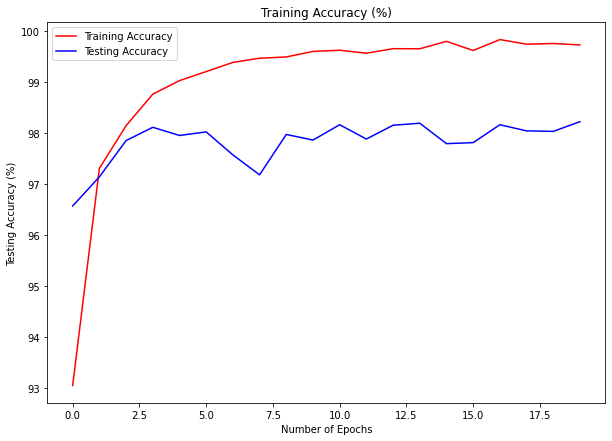

In [39]:
plt.figure(figsize = (10,7))

#Plot the training accuracy for each epoch
plt.plot(range(epochs), train_accuracy, 'r')
plt.title('Training Accuracy (%)')
plt.xlabel('Number of Epochs')
#Plot the testing accuracy for each epoch
plt.plot(range(epochs), test_accuracy, 'b')
plt.ylabel('Testing Accuracy (%)')
plt.legend(['Training Accuracy', 'Testing Accuracy'])
plt.show()

Even with a higher number of epochs the model is still not overfitting since both he train and test accuracy are quite high. 